# Inference

In [1]:
include("utils.jl"); using .Utils
checkpkgs("DataFrames", "CSV", "Distributions", "Plots", "KernelDensity", "StatsPlots", "StatsBase")

## Improving Reading Ability

In [2]:
getfile("https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv")

In [3]:
using DataFrames, Plots
import CSV

df = DataFrame(CSV.File("drp_scores.csv", delim="\t", header=23, skipto=24))
first(df, 3)

,Treatment,Response
,String,Int64
1,Treated,24
2,Treated,43
3,Treated,58


In [4]:
grouped = groupby(df, "Treatment")
responses = Dict()

for (k, group) in pairs(grouped)
    name = k["Treatment"]
    responses[name] = group[!, "Response"]
end

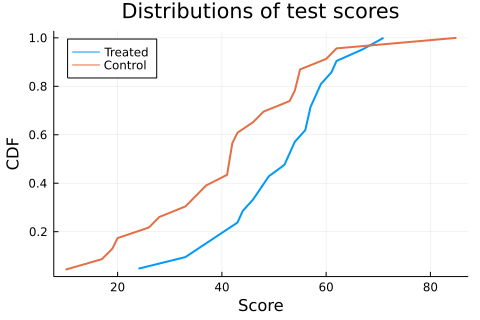

In [5]:
include("empiricaldist.jl"); using .EmpiricalDist
plot()
for (name, response) in pairs(responses)
    cdf = cdffromseq(response)
    plot!(cdf, label=name)
end

plot!(legend=:topleft, xlabel="Score", ylabel="CDF", title="Distributions of test scores")

## Estimating Parameters

In [6]:
"""Make a Pmf that represents a uniform distribution."""
function make_uniform(qs; name=nothing, kwargs...)
    pmf = Pmf(1.0, qs, name=name, kwargs...)
    normalize!(pmf)
    return pmf
end

make_uniform

In [7]:
qs = range(20, 80, length=101)
prior_mu = make_uniform(qs, name="mean");

In [8]:
qs = range(5, 30, length=101)
prior_sigma = make_uniform(qs, name="std");

In [9]:
prior = makejoint(prior_mu, prior_sigma);

In [10]:
data = responses["Control"]
size(data)

(23,)

## Likelihood

In [11]:
using Distributions

densities = [pdf(Normal(μ, σ), d) for σ ∈ prior.y, μ ∈ prior.x, d ∈ data]
size(densities)

(101, 101, 23)

In [12]:
likelihood = prod(densities, dims=3)[:,:,1]
size(likelihood)

(101, 101)

In [13]:
posterior = prior .* likelihood
normalize!(posterior)
size(posterior)

(101, 101)

In [14]:
"""Update the prior based on data."""
function update_norm(prior, data)
    likelihood = [prod(pdf.(Normal(μ, σ), data)) for σ ∈ prior.y, μ ∈ prior.x]
    
    posterior = prior .* likelihood
    normalize!(posterior)

    return posterior
end

update_norm

In [15]:
data = responses["Control"]
posterior_control = update_norm(prior, data);

In [16]:
data = responses["Treated"]
posterior_treated = update_norm(prior, data);

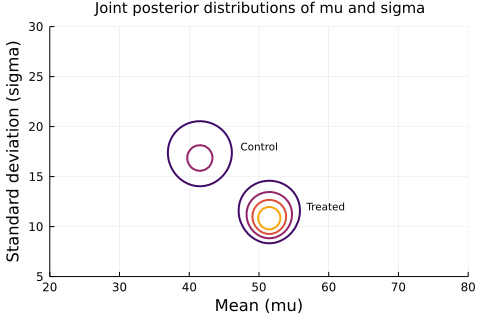

In [17]:
contour(posterior_control, cmap=cgrad(:haline), titlefontsize=10)
annotate!(50, 18, "Control", color=:blue, annotationfontsize=7)

contour!(posterior_treated, cmap=cgrad(:amp))
annotate!(59.5, 12, "Treated", color=:orange)

xlabel!("Mean (mu)")
ylabel!("Standard deviation (sigma)")
title!("Joint posterior distributions of mu and sigma")

## Posterior Marginal Distributions

In [18]:
pmf_mean_control = marginal(posterior_control, 1)
pmf_mean_treated = marginal(posterior_treated, 1);

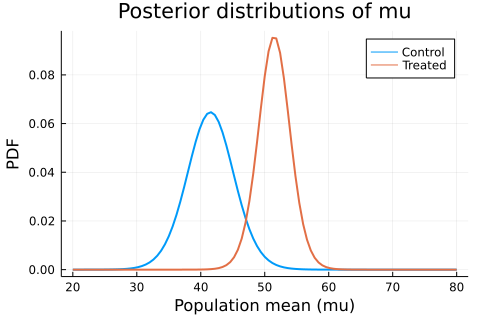

In [19]:
plot(pmf_mean_control, label="Control")
plot!(pmf_mean_treated, label="Treated")

xlabel!("Population mean (mu)")
ylabel!("PDF")
title!("Posterior distributions of mu")

In [20]:
prob_gt(pmf_mean_treated, pmf_mean_control)

0.980479025187326

## Distribution of Differences

In [21]:
pmf_diff = subdist(pmf_mean_treated, pmf_mean_control);

In [22]:
length(pmf_mean_treated), length(pmf_mean_control), length(pmf_diff)

(101, 101, 661)

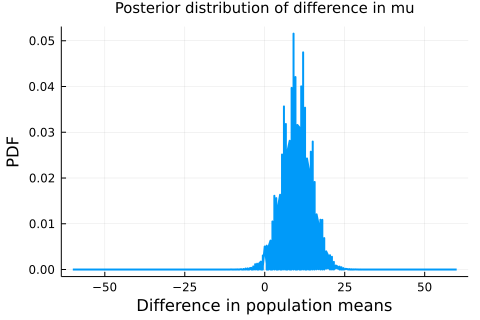

In [23]:
plot(pmf_diff,
     xlabel="Difference in population means",
     ylabel="PDF", 
     title="Posterior distribution of difference in mu",
     titlefontsize=10)

In [24]:
cdf_diff = makecdf(pmf_diff);

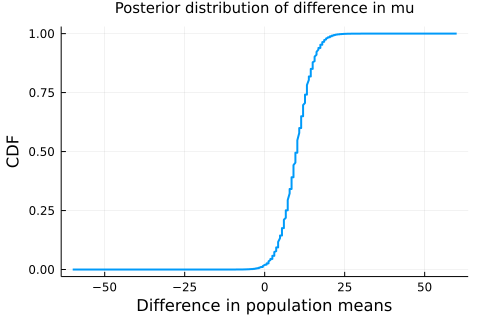

In [25]:
plot(cdf_diff,
         xlabel="Difference in population means", 
         ylabel="CDF", 
         title="Posterior distribution of difference in mu",
         titlefontsize=10)

In [26]:
using KernelDensity, StatsPlots, StatsBase

"""Make a kernel density estimate for a PMF."""
function kde_from_pmf(pmf; n=101)
    k = kde(pmf.qs; weights = pweights(pmf.ps))
    qs = range(extrema(pmf.qs)..., length=n)
    ps = pdf(k, qs)
    pmf = Pmf(ps, qs)
    normalize!(pmf)
    return pmf
end

kde_from_pmf

In [27]:
kde_diff = kde_from_pmf(pmf_diff);

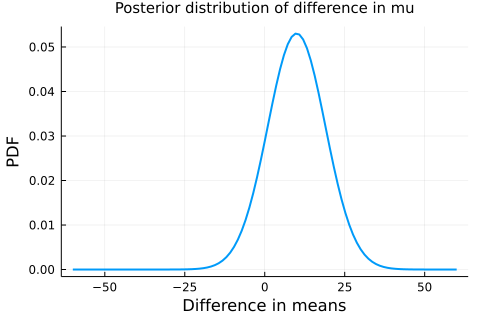

In [28]:
plot(kde_diff)

plot!(titlefontsize=10, xlabel="Difference in means",
      ylabel="PDF", title="Posterior distribution of difference in mu")

In [29]:
mean(pmf_diff)

9.954413088940852

In [30]:
credibleinterval(pmf_diff, 0.9)

2-element Vector{Float64}:
  2.3999999999999986
 17.4

## Using Summary Statistics

In [31]:
μ = 42
σ = 17;

In [32]:
n = 20
m = 41
s = 18;

In [33]:
dist_m = Normal(μ, σ/√n)

Normal{Float64}(μ=42.0, σ=3.801315561749642)

In [34]:
like1 = pdf(dist_m, m)
like1

0.10137915138497372

In [35]:
t = n * s^2 / σ^2
t

22.422145328719722

In [36]:
dist_s = Chisq(n-1);

In [37]:
like2 = pdf(dist_s, t)
like2

0.047364279094370125

In [38]:
like = like1 * like2
like

0.004801750420548295

## Update with Summary Statistics

In [39]:
summary = Dict()

for (name, response) in pairs(responses)
    summary[name] = length(response), mean(response), std(response)
end
summary

Dict{Any, Any} with 2 entries:
  "Treated" => (21, 51.4762, 11.0074)
  "Control" => (23, 41.5217, 17.1487)

In [40]:
n, m, s = summary["Control"]

(23, 41.52173913043478, 17.148733229699484)

In [41]:
μs = columns(prior)
σs = rows(prior);

In [42]:
like1 = pdf.(Normal.(μs',σs/sqrt(n)), m)
size(like1)

(101, 101)

In [43]:
ts = n .* s .^ 2 ./ σs .^ 2
like2 = pdf.(Chisq(n-1),ts)
size(like2)

(101,)

In [44]:
posterior_control2 = prior .* like1 .* like2
normalize!(posterior_control2)

0.0003096535101740279

In [45]:
"""Update a normal distribution using summary statistics."""
function update_norm_summary(prior, data)
    n, m, s = data
    μs, σs = columns(prior), rows(prior)
    
    like1 = pdf.(Normal.(μs',σs/√n), m)
    like2 = pdf.(Chisq(n-1), n .* s .^ 2 ./ σs .^ 2)
    
    posterior = prior .* like1 .* like2
    normalize!(posterior)
    
    return posterior
end

update_norm_summary

In [46]:
data = summary["Treated"]
posterior_treated2 = update_norm_summary(prior, data);

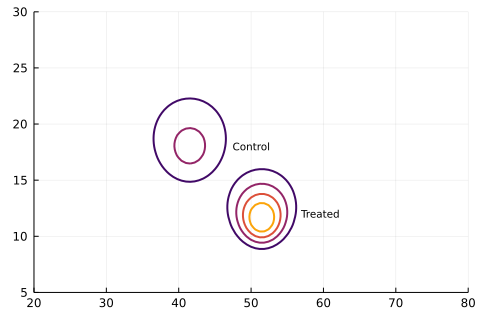

In [47]:
contour(posterior_control2, cmap=cgrad(:haline), titlefontsize=10)
annotate!(50, 18, "Control", color=:blue, annotationfontsize=7)

contour!(posterior_treated2, cmap=cgrad(:amp))
annotate!(59.5, 12, "Treated", color=:orange)

## Comparing Marginals

In [48]:
pmf_mean_control2 = marginal(posterior_control2, 1)
pmf_mean_treated2 = marginal(posterior_treated2, 1);

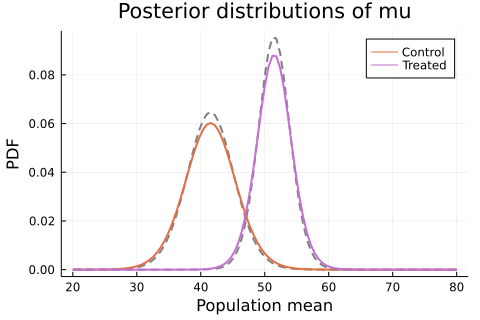

In [49]:
plot(pmf_mean_control, color=:gray, linestyle=:dash, label="")
plot!(pmf_mean_control2, label="Control")
plot!(pmf_mean_treated, color=:gray, linestyle=:dash, label="")
plot!(pmf_mean_treated2, label="Treated")

xlabel!("Population mean") 
ylabel!("PDF")
title!("Posterior distributions of mu")

## Proof By Simulation

In [50]:
μ = 42
σ = 17

17

In [51]:
dist = Normal(μ, σ)

Normal{Float64}(μ=42.0, σ=17.0)

In [52]:
n = 20
samples = rand(dist,(1000, n))
size(samples)

(1000, 20)

In [53]:
sample_means = mean(samples, dims=2)
# Julia returns a 2D array (matrix):
# size(sample_means) == (1000, 1)
#
# to get a vector we can, e.g.
sample_means = sample_means[:, 1]
size(sample_means)

(1000,)

In [54]:
"""Make a discrete approximation of a continuous distribution.

dist: Disribution object
low: low end of range
high: high end of range

returns: normalized Pmf
"""
function pmf_from_dist(dist, low, high)
    qs = range(low, high, length=101)
    ps = pdf.(dist, qs)
    pmf = Pmf(ps, qs)
    normalize!(pmf)
    return pmf
end

pmf_from_dist

In [55]:
low = mean(dist_m) - 3std(dist_m)
high = mean(dist_m) + 3std(dist_m)

pmf_m = pmf_from_dist(dist_m, low, high);

In [56]:
qs = pmf_m.qs
pmf_sample_means = kde_from_sample(sample_means, qs);

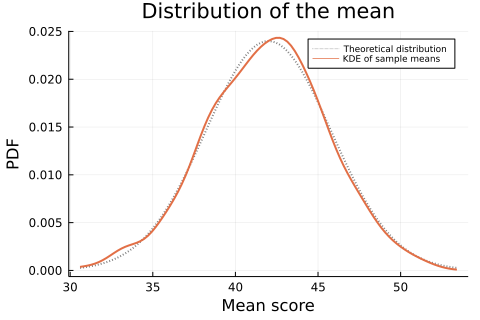

In [57]:
plot(pmf_m, label="Theoretical distribution",
           style=:dot, color=:gray)
plot!(pmf_sample_means, label="KDE of sample means",
     xlabel="Mean score", ylabel="PDF", 
     title="Distribution of the mean", legendfontsize=6)

## Checking Standard Deviation

In [58]:
sample_stds = std(samples, dims=2)[:, 1]
size(sample_stds)

(1000,)

In [59]:
transformed = n .* sample_stds .^ 2 ./ σ .^ 2;

In [60]:
dist_s = Chisq(n-1);

In [61]:
low = 0
high = mean(dist_s) + 4std(dist_s)

pmf_s = pmf_from_dist(dist_s, low, high);

In [62]:
qs = pmf_s.qs
pmf_sample_stds = kde_from_sample(transformed, qs);

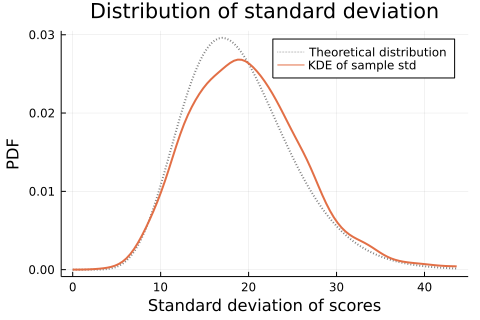

In [63]:
plot(pmf_s, label="Theoretical distribution",
           style=:dot, color=:gray)
plot!(pmf_sample_stds, label="KDE of sample std",
         xlabel="Standard deviation of scores",
         ylabel="PDF",
         title="Distribution of standard deviation")

In [64]:
cor(sample_means, sample_stds)

-0.047438033866512117

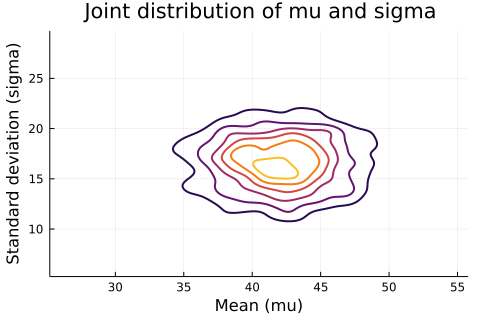

In [65]:

plot(kde((sample_means, sample_stds)), 
         xlabel="Mean (mu)",
         ylabel="Standard deviation (sigma)",
         title="Joint distribution of mu and sigma",
         levels=6)

## Summary

## Exercises

In [66]:
# Solution

pmf_std_control = marginal(posterior_control, 2)
pmf_std_treated = marginal(posterior_treated, 2);

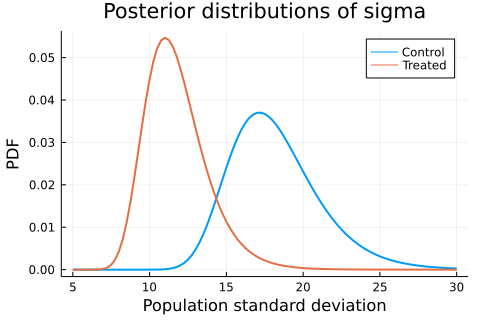

In [67]:
# Solution

plot(pmf_std_control, label="Control")
plot!(pmf_std_treated, label="Treated")

xlabel!("Population standard deviation")
ylabel!("PDF")
title!("Posterior distributions of sigma")

In [68]:
# Solution

prob_gt(pmf_std_control, pmf_std_treated)

0.968510337530047

In [69]:
# Solution

pmf_diff2 = subdist(pmf_std_control, pmf_std_treated);

In [70]:
# Solution

mean(pmf_diff2)

6.41717132817218

In [71]:
# Solution

credibleinterval(pmf_diff2, 0.9)

2-element Vector{Float64}:
  1.0
 12.5

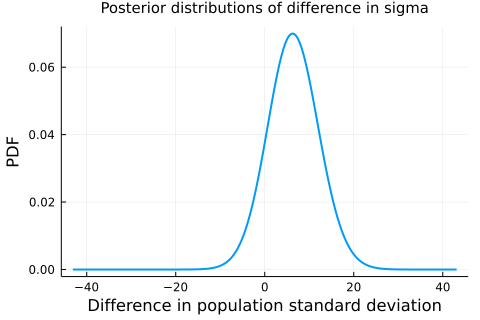

In [72]:
# Solution

plot(kde(pmf_diff2),
    xlabel="Difference in population standard deviation", 
    ylabel="PDF", title="Posterior distributions of difference in sigma",
    titlefontsize=10)

In [73]:
"""Draw a sample from a joint distribution.

joint: JointDistribution representing a joint distribution
size: sample size
"""
sample_joint(joint, size) = sample(stack(transpose(joint)), size)

sample_joint

In [74]:
sample_treated = sample_joint(posterior_treated, 1000)
size(sample_treated)

(1000,)

In [75]:
sample_control = sample_joint(posterior_control, 1000)
size(sample_control)

(1000,)

In [76]:
# Solution
"""Compute Cohen's effect size for difference in means.

pair1: tuple of (μ₁, σ₁)
pair2: tuple of (μ₂, σ₂)

return: float
"""
function cohen_effect(pair1, pair2)
    μ₁, σ₁ = pair1 
    μ₂, σ₂ = pair2
    σ = (σ₁ + σ₂) / 2
    return (μ₁ - μ₂) / σ
end

cohen_effect

In [77]:
cohen_effect(sample_treated[1], sample_control[1])

0.7124999999999999

In [78]:
# Solution

ds = []
for (pair1, pair2) in zip(sample_treated, sample_control)
    d = cohen_effect(pair1, pair2)
    push!(ds, d)
end

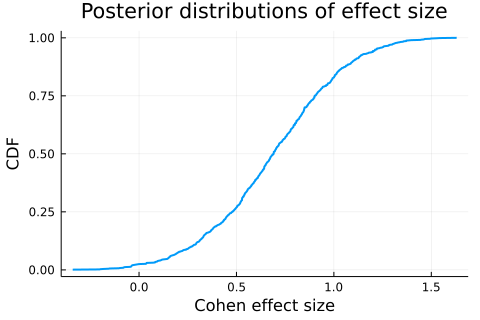

In [79]:
# Solution

cdf = cdffromseq(ds)
plot(cdf,
    xlabel="Cohen effect size",
    ylabel="CDF",
    title="Posterior distributions of effect size")

In [80]:
# Solution

mean(cdf)

0.6867791333776689

In [81]:
# Solution

credibleinterval(cdf, 0.9)

2-element Vector{Float64}:
 0.14883720930232594
 1.2196721311475411

In [82]:
# Solution

# Based on trial and error, here's a range of
# values for the prior

hypos = range(1, 51, length=101)

1.0:0.5:51.0

In [83]:
# Solution

# Here are the probabilities of a score greater than 90
# for each hypothetical value of sigma.

pgt90 = ccdf.(Normal.(81, hypos), 90)
size(pgt90)

(101,)

In [84]:
# Solution

# And here's the chance that 5 out of 25 people
# get a score greater than 90

likelihood1 = pdf.(Binomial.(25, pgt90), 5)
size(likelihood1)

(101,)

In [85]:
# Solution

# Here's the first update

prior = Pmf(1, hypos)
posterior = prior .* likelihood1
normalize!(posterior)

5.299480018256256

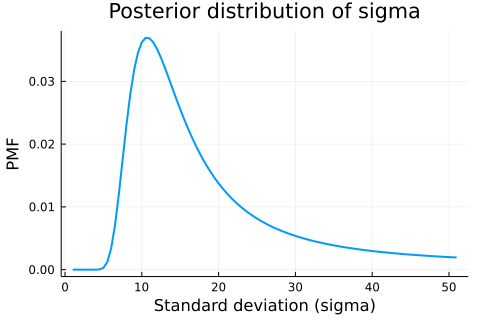

In [86]:
# Solution

# Here's the first posterior.

plot(posterior, 
         xlabel="Standard deviation (sigma)",
         ylabel="PMF",
         title="Posterior distribution of sigma")

In [87]:
# Solution

# Here's the probability of a score greater than 60

pgt60s = ccdf.(Normal.(81, hypos), 60)
size(pgt60s)

(101,)

In [88]:
# Solution

# And here's the probability that all 25 students exceed 60

likelihood2 = pgt60s .^ 25;

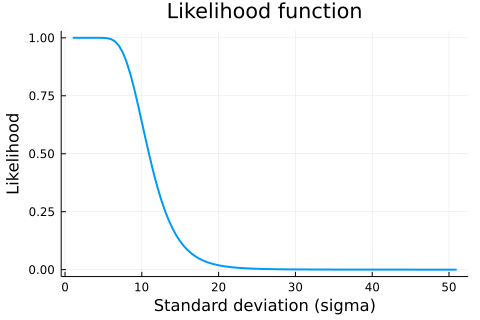

In [89]:
# Solution

plot(hypos, likelihood2,
         xlabel="Standard deviation (sigma)",
         ylabel="Likelihood",
         title="Likelihood function")

In [90]:
# Solution

# Here's the posterior after both updates

prior = Pmf(1, hypos)
normalize!(prior)
posterior2 = prior .* likelihood1 .* likelihood2
normalize!(posterior2)

0.014254555311295644

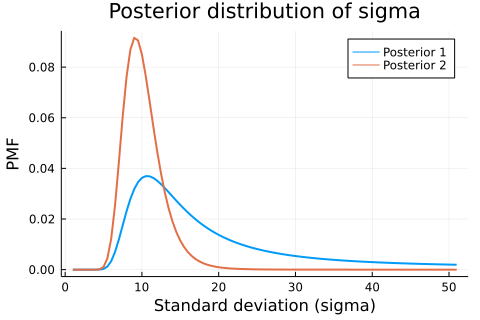

In [91]:
# Solution

plot(posterior, label="Posterior 1")
plot!(posterior2, label="Posterior 2")

xlabel!("Standard deviation (sigma)")
ylabel!("PMF")
title!("Posterior distribution of sigma")

In [92]:
# Solution

mean(posterior), mean(posterior2)

(18.150261186811555, 10.189707962198527)

In [93]:
# Solution

credibleinterval(posterior2, 0.9)

2-element Vector{Float64}:
  7.0
 15.0

In [94]:
"""Get the posterior distribution of CV.

joint: joint distribution of mu and sigma

returns: Pmf representing the smoothed posterior distribution
"""
function get_posterior_cv(joint)
    pmf_mu = marginal(joint, 1)
    pmf_sigma = marginal(joint, 2)
    pmf_cv = divdist(pmf_sigma, pmf_mu)
    return kde_from_pmf(pmf_cv)
end

get_posterior_cv

In [95]:
# Solution

n = 154407
μ = 178
σ = 8.27;

In [96]:
# Solution

qs = range(μ-0.1, μ+0.1, length=101)
prior_mu = makeuniform(qs, name="mean")

qs = range(σ-0.1, σ+0.1, length=101)
prior_sigma = makeuniform(qs, name="std")

prior = makejoint(prior_mu, prior_sigma);

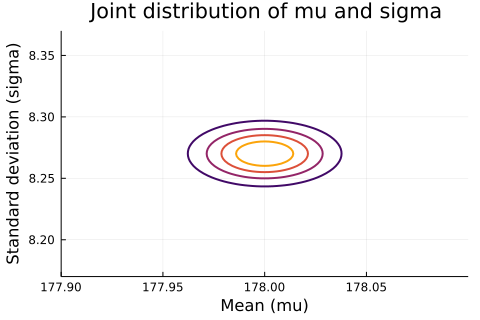

In [97]:
# Solution

data = n, μ, σ
posterior_male = update_norm_summary(prior, data)
contour(posterior_male, cmap=cgrad(:haline),
         xlabel="Mean (mu)", 
         ylabel="Standard deviation (sigma)",
         title="Joint distribution of mu and sigma")

In [98]:
# Solution

n = 254722
μ = 163
σ = 7.75;

In [99]:
# Solution

qs = range(μ-0.1, μ+0.1, length=101)
prior_mu = makeuniform(qs, name="mean")

qs = range(σ-0.1, σ+0.1, length=101)
prior_sigma = makeuniform(qs, name="std")

prior = makejoint(prior_mu, prior_sigma);

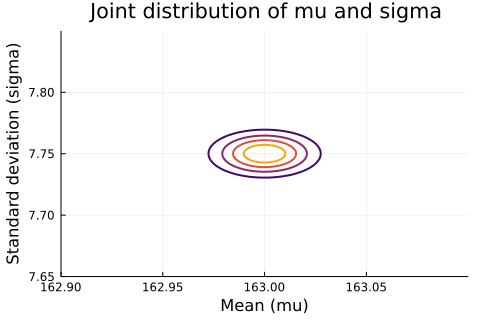

In [100]:
# Solution

data = n, μ, σ
posterior_female = update_norm_summary(prior, data)
contour(posterior_female, cmap=cgrad(:hot),
         xlabel="Mean (mu)", 
         ylabel="Standard deviation (sigma)",
         title="Joint distribution of mu and sigma")

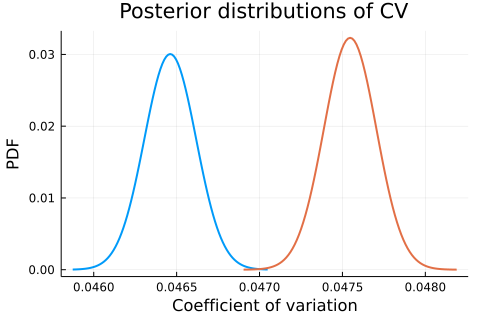

In [101]:
# Solution

pmf_cv_male = get_posterior_cv(posterior_male)
plot(kde_from_pmf(pmf_cv_male))

pmf_cv_female = get_posterior_cv(posterior_female)
plot!(kde_from_pmf(pmf_cv_female))

plot!(xlabel="Coefficient of variation",
         ylabel="PDF",
         title="Posterior distributions of CV")

In [102]:
# Solution

ratio_cv = divdist(pmf_cv_female, pmf_cv_male)
maxprob(ratio_cv)

1.0233615721208176

In [103]:
# Solution

credibleinterval(ratio_cv, 0.9)

2-element Vector{Float64}:
 1.0187903025399536
 1.0279325306573268